In [172]:
import pandas as pd
import numpy as np
import ruptures as rp
from prediction_pipeline.preprocessing import *
from sklearn.linear_model import LinearRegression
from glob import glob
%load_ext autoreload
%autoreload 2

from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.cross_decomposition import PLSRegression
from collections import defaultdict 
from scipy.stats import pearsonr
from sklearn.metrics import r2_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.preprocessing import RobustScaler
import os
import subprocess

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [173]:
data_dir = "/home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hv270/data_home"
export_folder = "/home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hippolyte_only/interval_processing"

In [174]:
tag = "27_july"
tag_path = "%s/%s" % (export_folder,tag) 
tag_score_path = "%s/Genetic_score/%s" % (export_folder,tag) 
if not os.path.exists(tag_path): os.mkdir(tag_path)
if not os.path.exists(tag_score_path): os.mkdir(tag_score_path)

# Tags

## 9jun

- factor analysis pour décomposer les scattergrams.
- PLS pour l'ajustement des features et l'estimation par les covariates
- PCT enlevé des covariates, IPF y est bien par contre
- N_PLS_COMPS = 1

## 10jun

idem + :
- phase A & B, 2K cellules / scattergram

## 11jun

idem + :
- PCT gardé comme covariate
- PCA pour les features au lieu de FA
- ajustement des features par PLS mais avec 3 composantes. PLS fittée séparément pour int et sys

jusqu'ici, PEAR1 avait une P-value autour de 0,1... mais avec ça, elle passe à 1E-7. C'est bien, mais il faut pousser encore. Je pense que c'est l'ajustement qui compte beaucoup.

## 11jun_WE

idem + :
- 4 composantes dans la PLS d'ajustement
- On essaie le GWAS sur les _FIB

-> On a PEAR1 ! :) 

## 15jun

idem + :
- normalisé chaque features par sa STD après ajustement, séparément pour train et pour interval

-> Ca marche moins bien...

## 16jun

- enlevé la normalisation
- Remarqué que la covariance est différente entre les variables ajustées de INT et de TRAIN, donc X_int = PCA_train_inv(PCA_int(X_int))

-> Ne marche pas

## 21 juin

- même process, en sélectionnant moins de features (6)

-> PEAR1 est à 4e-7 en PLINK. À suivre

## 21 juin no_pca

- même process, enlevé la PCA

-> 4e-7 mais Beta opposé !?

## 21jun_nopca_3feats

- on ne garde que 3 features

-> 6e-7

## 21jun_3feats_fixedpca

- Problème de PCA résolu : on s'assure que les composantes des PCA post-ajustement sont à peu près les mêmes (on ne vérifiait pas que les signes concordaient...)

-> Marche pas mieux, la PCA n'est pas adaptée

## 22jun_cholesky

- On décorrèle et recorrèle les données avec une Cholesky
- On repasse avec 6 features
- On clippe à -4 - +4
- On remultiplie par les STD post-ajustement -> 1e-7 !

## 22jun_cholesky_3feats

- idem avec 3 features
- Vu qu'il y a peu de features, on utilise juste une régression linéaire à la place de la PLS pour la prédiction des phenotypes. Ca marche mieux (on explique plus de R^2) -> 8e-7

## 22jun_cholesky_3feats_adjust

- en plus, on fait un ajustement à la toute fin du processus

-> 7e-7

## 22jun_3feats_adjust

- No cholesky
- min cohort size = 200

-> 1.7e-7

## 22jun_adjust

- Back to 6 features

-> 2e-8 !!

## 22jun_adj_feats

- Adjust features before fit and prediction
- PLS instead of LR
- back to all features

-> 4.7e-9 !

- Try adding cholesky adjustment, it breaks the p-value. Maybe there's a better way to 

## 25jun_sep_PCA

- Try to use different PCAs for both cohorts

-> 2e-8

## 5_july_gating

- Changed gating
- Kept more platelets per sample
- Kept individuals with PLT count discrepancies
- Same PCA for both cohorts

## 26 july

- Filter upper left corner (kept first rows of .fcs and .116 files)
- adjust STD of scatter signal -> marche pas

## 27 july

- PCA par individu
- annulé l'ajustement STD

# Matching tables

In [318]:
matching = pd.read_csv("/home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hippolyte_only/interval_phenotypes/INTERVAL_OmicsMap_20200514.csv", sep=",")
has_one_id = ~matching["Affymetrix_QC_bl"].isnull() | ~matching["Affymetrix_QC_24m"].isnull()
matching = matching.loc[has_one_id]
matching["AffyID"] = matching["Affymetrix_QC_bl"]
matching.loc[matching.AffyID.isnull(),"AffyID"] = matching.loc[matching.AffyID.isnull(),"Affymetrix_QC_24m"]

In [319]:
int_phen, meta = get_INTERVAL_phenotypes()

Loading INTERVAL phenotypes
(48460, 760)
(45040, 760)
(38832, 760)
(112535, 11)
(102595, 11)
(17768, 772)
(32574, 777)
(32727, 777)
Checked that each Sample has one row max


In [320]:
meta = pd.merge(matching,int_phen,left_on="identifier", right_on="identifier")
meta["IID"] = meta["AffyID"].astype(int).astype(str)
meta["FID"] = meta["AffyID"].astype(int).astype(str)

meta["cohort"] = meta.interval

In [321]:
meta.sample(3)

,identifier,Affymetrix_QC_bl,Affymetrix_gwasQC_bl,Affymetrix_QC_24m,Affymetrix_gwasQC_24m,AffyID,FileName,SampleNo,Instrument,DateTime,...,HBF_48m,in_cohort,PLT_10_9_L_bl,PDW_fL_bl,MPV_fL_bl,PCT_PCT_bl,IPF_bl,IID,FID,cohort
29507,1113399,1.100011e+11,1.100011e+11,NaN,NaN,1.100011e+11,[XN-10^11041][00-15_5][20150528_095552][ ...,INT_116_5753300,XN-10^11041,2015-05-28 09:55:52,...,NaN,24,NaN,NaN,NaN,NaN,NaN,110001053514,110001053514,F12
13912,1052953,1.100182e+11,1.100182e+11,NaN,NaN,1.100182e+11,[XN-10^11036][00-15_5][20150103_092220][ ...,INT_116_895900,XN-10^11036,2015-01-03 09:22:20,...,NaN,24,255.0,13.6,11.5,0.27,5.2,110018196696,110018196696,M10
20224,1077682,1.100014e+11,1.100014e+11,NaN,NaN,1.100014e+11,[XN-10^11036][00-13_16][20130611_105959][ ...,INT_116_253800,XN-10^11036,2013-06-11 10:59:59,...,NaN,BL,NaN,NaN,NaN,NaN,NaN,110001383887,110001383887,F14


In [322]:
meta.cohort.value_counts()

M12    5288
M10    5253
F14    5236
F12    5197
M08    5181
F16    5141
Name: cohort, dtype: int64

In [323]:
meta.in_cohort.value_counts()

BL    17192
24    13962
48      142
Name: in_cohort, dtype: int64

In [324]:
meta["cohort_covar"] = 0
for i, c in enumerate(meta["in_cohort"].unique().tolist()):
    meta.loc[meta["in_cohort"] == c,"cohort_covar"] = i
meta["age_covar"] = RobustScaler().fit_transform(meta[["Age"]])
meta["instrument_covar"] = 1*(meta.Instrument == "XN-10^11041")

pcs = pd.read_csv("%s/principal_components/PC.eigenvec" % export_folder,sep="\t")
pcs["IID"] = pcs["IID"].astype(str)

In [325]:
match = int_phen.loc[int_phen.ethnicPulse == "Eng/W/Scot/NI/Brit",["SampleNo","identifier"]]
match["valid_id"] = match["identifier"].astype(int)
print(match.shape)

(32727, 3)


In [326]:
sysmex_features = pd.read_csv("%s/processed/sysmex_features.csv" % data_dir,index_col=0)
sys_agesex, int_agesex = get_ages_sex()
agesex = pd.concat((sys_agesex,int_agesex),axis=0)
print(agesex.shape[0])
print(sysmex_features.shape[0])
covar = pd.merge(agesex, sysmex_features,left_index=True,right_index=True,how="inner")
print(covar.shape[0])
covar.sample(3)

Loading INTERVAL phenotypes
(48460, 760)
(45040, 760)
(38832, 760)
(112535, 11)
(102595, 11)
(17768, 772)
(32574, 777)
(32727, 777)
Checked that each Sample has one row max
34924
33362
33362


,SEX,AGE,PLT,MPV,PDW,PCT,IPF
INT_116_2769100,2,53.6,245.976209,9.921744,11.003691,0.234699,2.073110
INT_116_2247600,1,54.2,202.941263,12.643503,18.477990,0.247900,8.583813
INT_116_2610200,1,64.7,138.962634,11.006651,12.493116,0.157605,2.733292


In [327]:
bkps_cohort = pd.read_csv("%s/processed/bkpts_cohorts.csv" % data_dir).set_index("SampleNo")
bkps_cohort.rename(columns={"cohort":"bkps_cohort"},inplace=True)
bkps_cohort["bkps_cohort"] = "BKP_" + bkps_cohort["bkps_cohort"].astype(str)
#covar = pd.merge(covar, pd.get_dummies(bkps_cohort["bkps_cohort"],drop_first=True),left_index=True,right_index=True)
covar = pd.merge(covar, bkps_cohort, left_index=True,right_index=True)

In [328]:
covar

,SEX,AGE,PLT,MPV,PDW,PCT,IPF,bkps_cohort
INT_116_6580100,1,58.8,212.891013,10.929374,13.683966,0.218759,2.18012,BKP_0
INT_116_6580000,2,22.6,235.891013,11.329374,14.783966,0.268759,3.28012,BKP_0
INT_116_4555900,2,59.4,143.891013,11.829374,12.883966,0.148759,2.88012,BKP_0
INT_116_4555800,2,21.3,197.891013,12.229374,16.183966,0.248759,3.98012,BKP_0
INT_116_4556000,1,49.3,265.891013,11.329374,14.183966,0.298759,2.08012,BKP_0
...,...,...,...,...,...,...,...,...
INT_116_6536800,2,42.5,249.795602,11.308924,14.267735,0.273207,3.04059,BKP_32
INT_116_1943800,2,61.6,208.795602,11.408924,13.867735,0.243207,2.64059,BKP_15
INT_116_4535600,1,47.4,385.795602,9.608924,10.467735,0.353207,0.34059,BKP_32
INT_116_6545900,1,37.0,219.795602,11.208924,13.767735,0.253207,2.24059,BKP_32


In [329]:
covars = pd.merge(covar,
                 meta.loc[meta.ethnicPulse == "Eng/W/Scot/NI/Brit"].set_index("SampleNo")[["FID","IID","age_covar","cohort_covar"]],
                left_index=True,right_index=True)
covars = pd.merge(covars,pcs[pcs.columns[1:]],left_on="IID",right_on="IID")
covars = covars[["FID","IID"] + [c for c in covars.columns if c not in ["IID","FID"]]]
covars = covars.dropna(axis=0,how="any")

#covars["cohort_covar"] = "C_" + covars["cohort_covar"].astype(str)

del covars["AGE"]

In [330]:
covars.head()

,FID,IID,SEX,PLT,MPV,PDW,PCT,IPF,bkps_cohort,age_covar,...,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
0,110006795043,110006795043,1,212.891013,10.929374,13.683966,0.218759,2.18012,BKP_0,0.546610,...,-0.006143,-0.003414,-0.002550,-0.006617,0.007619,0.000518,-0.005138,-0.001251,-0.001450,-0.000475
1,110004131286,110004131286,2,235.891013,11.329374,14.783966,0.268759,3.28012,BKP_0,-0.987288,...,-0.002604,-0.000270,0.007260,-0.000367,0.004252,0.004225,0.002824,-0.006574,0.008446,0.005722
2,110006795026,110006795026,2,143.891013,11.829374,12.883966,0.148759,2.88012,BKP_0,0.572034,...,0.006994,0.005321,-0.006430,0.002057,-0.001391,-0.005765,-0.005126,-0.006106,-0.001899,-0.011991
3,110004131285,110004131285,1,265.891013,11.329374,14.183966,0.298759,2.08012,BKP_0,0.144068,...,-0.000951,0.008243,-0.000835,-0.004595,-0.002367,0.006899,0.004903,0.001809,-0.000368,-0.000548
4,110006494505,110006494505,2,312.891013,11.329374,14.183966,0.358759,2.98012,BKP_0,0.228814,...,-0.001484,0.000059,-0.006912,0.007134,0.001031,0.000255,0.003179,0.004252,0.002089,0.009268


In [331]:
phenotypes = pd.read_csv("%s/processed/predictions.csv" % data_dir,index_col=0)
phenotypes = pd.merge(phenotypes,
                 meta.loc[meta.ethnicPulse == "Eng/W/Scot/NI/Brit"].set_index("SampleNo")[["FID","IID"]],
                left_index=True,right_index=True)
phenotypes = pd.merge(phenotypes,pcs[pcs.columns[1:]],left_on="IID",right_on="IID")
phenotypes = phenotypes[["FID","IID"] + [c for c in phenotypes.columns if c not in ["IID","FID"] and "PC" not in c]]
phenotypes = phenotypes.dropna(axis=0,how="any")

In [332]:
phenotypes.sample(3)

,FID,IID,ADP_PSEL,ADP_FIB,ADP,CRP_PSEL,CRP_FIB,CRP,TRAP_PSEL,TRAP_FIB,TRAP,PAR1_PSEL,PAR1_FIB,PAR1,PAR4_PSEL,PAR4_FIB,PAR4
28153,110017081195,110017081195,-0.056682,-0.058159,-0.056573,-0.016124,-0.019573,-0.018660,-0.050553,-0.064608,-0.052405,-0.044962,-0.061165,-0.053219,-0.041356,-0.041453,-0.041066
3604,110017385941,110017385941,-0.186938,-0.288359,-0.240320,-0.273704,-0.273996,-0.265753,-0.033833,-0.129629,-0.088723,-0.080762,-0.175725,-0.132750,-0.168014,-0.234370,-0.201486
29227,110005899904,110005899904,0.579860,0.586966,0.578159,0.498883,0.478480,0.481987,0.423378,0.537528,0.461093,0.375900,0.547487,0.483589,0.439991,0.488414,0.451682


In [333]:
cov_ids = covars.IID.unique().tolist()
phen_ids = phenotypes.IID.unique().tolist()
covars = covars.loc[covars.IID.isin(phen_ids)].sort_values(by="IID")
phenotypes = phenotypes.loc[phenotypes.IID.isin(cov_ids)].sort_values("IID")
print(covars.shape)
print(phenotypes.shape)

(29866, 21)
(29866, 17)


In [334]:
phenotypes.to_csv("%s/%s/phenotypes.csv" % (export_folder,tag), index=False,header=True, sep="\t")
covars.to_csv("%s/%s/covars.csv" % (export_folder,tag), index=False,header=True, sep="\t")

In [335]:
covars.columns

Index(['FID', 'IID', 'SEX', 'PLT', 'MPV', 'PDW', 'PCT', 'IPF', 'bkps_cohort',
       'age_covar', 'cohort_covar', 'PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6',
       'PC7', 'PC8', 'PC9', 'PC10'],
      dtype='object')

In [336]:
covars.sample(1)

,FID,IID,SEX,PLT,MPV,PDW,PCT,IPF,bkps_cohort,age_covar,...,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
2678,110000835224,110000835224,2,306.891013,11.029374,13.083966,0.328759,3.98012,BKP_16,-1.084746,...,-0.006664,0.000108,0.001067,0.004525,0.0031,0.006161,-0.002703,-0.00376,-0.002228,0.002598


In [345]:
excluded_cohorts = []
#excluded_cohorts = ["BKP_%d" % i for i in range(16,20)]

In [343]:
with open("%s/all_int_fids" % tag_path,"w") as file:
    for FID in covars.loc[covars.bkps_cohort.isin(excluded_cohorts)].FID.unique():
        file.write("%s %s\n" % (FID, FID))

# Launch GWAS (Plink, only CHR 1)

In [344]:
k = 1
n_splits = 1

command = "/home/hv270/plink2 "

command += "--bfile /home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hv270/interval_genotypes/chr_%d " % k
command += "--glm hide-covar"
#command += " --keep %s/king-cutoff.king.cutoff.in.id" % export_folder
command += " --keep %s/all_int_fids" % tag_path
command += " --extract /home/hv270/pear1"
command += " --pheno %s/%s/phenotypes.csv" % (export_folder, tag)
command += " --covar %s/%s/covars.csv" % (export_folder, tag)
command += " --out %s/%s/chr_%d" % (export_folder, tag,k)
command += " --threads %d" % n_splits
command += " --covar-variance-standardize"

f_name = "/home/hv270/interval_slurm_calls/call_chr_%d.sh" % k
f = open(f_name,"w+")
f.write("#!/bin/sh\n")

f.write("#SBATCH -J chr_%d\n" % k)
f.write("#SBATCH -A ASTLE-SL2-CPU\n")
f.write("#SBATCH -N 1\n")
f.write("#SBATCH -n %d\n" % n_splits)
#f.write("#SBATCH -c %d\n" % n_splits)
f.write("#SBATCH --time=0:02:00\n")
f.write("#SBATCH -p skylake-himem\n")
f.write("#SBATCH --output=/home/hv270/slurm_log/%s_%s.out\n" % (tag,k))
f.write("export OMP_NUM_THREADS=%d\n" % n_splits)

f.write(". /etc/profile.d/modules.sh\n")
f.write("module purge\n")
f.write("module load rhel7/default-peta4\n")
f.write(command)
f.close()

print("Submitting %d" % k)
#p = subprocess.Popen("sbatch %s" % f_name,shell=True)
p = subprocess.Popen(command,shell=True)
p.wait()

Submitting 1


0

In [278]:
grep rs12566888 interval_processing/26_july/bolt_res_feb_ADP

SyntaxError: invalid syntax (<ipython-input-278-812e15f40d5d>, line 1)

# Launch GWAS (BOLT LMM)

In [355]:
n_splits = 16

In [356]:
pheno_cols = ["ADP","CRP","TRAP","PAR4","PAR1"]
#pheno_cols += ["%s_FIB" % p for p in pheno_cols]
print(pheno_cols)

['ADP', 'CRP', 'TRAP', 'PAR4', 'PAR1']


In [357]:
for pheno in pheno_cols:

    command = "/home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hv270/BOLT-LMM_v2.3.4/bolt "
    for k in range(1,23):
        command += "--bim=/home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hv270/interval_genotypes/chr_%d.bim " % k
    # Only one fam file has to be specified
    command += "--fam=/home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hv270/interval_genotypes/chr_1.fam "
    for k in range(1,23):
        command += "--bed=/home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hv270/interval_genotypes/chr_%d.bed " % k
    command += "--lmm \
        --LDscoresFile=/home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hv270/BOLT-LMM_v2.3.4/tables/LDSCORE.1000G_EUR.tab.gz \
        --phenoFile=%s/%s/phenotypes.csv \
        --phenoCol=%s \
        --covarFile=%s/%s/covars.csv \
        --maxMissingPerSnp=0.1 \
        --qCovarCol=PLT \
        --qCovarCol=MPV \
        --qCovarCol=PDW \
        --qCovarCol=PCT \
        --qCovarCol=IPF \
        --qCovarCol=age_covar \
        --covarCol=SEX \
        --covarCol=cohort_covar \
        --covarMaxLevels=20 \
        --statsFile=%s/%s/bolt_res_feb_%s \
        --statsFileBgenSnps=%s/%s/bolt_res_bgen_feb_%s \
        --modelSnps=/home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hv270/indep_snps \
        --bgenFile=/home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/alexander_only/impute_{1:22}_interval.bgen \
        --bgenMinMAF=1e-3 \
        --bgenMinINFO=0.4 \
        --lmmForceNonInf \
        --sampleFile=/home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/alexander_only/interval.sample \
        --numThreads=%d" % (export_folder, tag,
                            pheno,
                            export_folder, tag,
                            export_folder,
                            tag,
                            pheno,
                            export_folder, tag,
                            pheno,
                            n_splits)

    f_name = "/home/hv270/interval_slurm_calls/call_%s.sh" % pheno
    f = open(f_name,"w+")
    f.write("#!/bin/sh\n")

    f.write("#SBATCH -J %s\n" % (pheno))
    f.write("#SBATCH -A ASTLE-SL2-CPU\n")
    f.write("#SBATCH -N 1\n")
    f.write("#SBATCH -n %d\n" % n_splits)
    #f.write("#SBATCH -c %d\n" % n_splits)
    f.write("#SBATCH --time=8:00:00\n")
    f.write("#SBATCH -p skylake\n")
    f.write("#SBATCH --output=/home/hv270/slurm_log/%s_%s.out\n" % (tag,pheno))
    f.write("export OMP_NUM_THREADS=%d\n" % n_splits)

    f.write(". /etc/profile.d/modules.sh\n")
    f.write("module purge\n")
    f.write("module load rhel7/default-peta4\n")
    f.write(command)
    f.close()

    print("Submitting %s" % pheno)
    p = subprocess.Popen("sbatch %s" % f_name,shell=True,stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    p.wait()

Submitting ADP
Submitting CRP
Submitting TRAP
Submitting PAR4
Submitting PAR1


# Bonus : compare predictions across tags

In [99]:
tag1 = "11jun_WE"
tag2 = "16jun"

In [109]:
preds_1 = pd.read_csv("%s/%s/phenotypes.csv" % (export_folder,tag1),index_col=0, sep="\t")
preds_2 = pd.read_csv("%s/%s/phenotypes.csv" % (export_folder,tag2),index_col=0, sep="\t")

In [110]:
comp = pd.merge(preds_1,preds_2,left_index=True,right_index=True,how="inner",suffixes=("_1","_2"))

Text(0.5, 1.0, 'ADP')

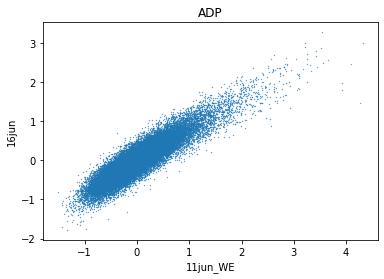

In [111]:
pheno = "ADP"
plt.scatter(comp[pheno+"_1"],comp[pheno+"_2"],s=.1)
plt.xlabel(tag1)
plt.ylabel(tag2)
plt.title(pheno)